<a href="https://colab.research.google.com/github/mmawesome8148-cell/Kaggle-Study/blob/main/%F0%9F%8D%BF%F0%9F%A5%A4Netflix_Movies_and_TV_Shows_Clustering_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
bansodesandeep_netflix_movies_and_tv_shows_path = kagglehub.dataset_download('bansodesandeep/netflix-movies-and-tv-shows')

print('Data source import complete.')


100%|██████████| 1.18M/1.18M [00:00<00:00, 29.5MB/s]

Extracting files...
Data source import complete.


# <b><u> Project Title : Netflix Movies and TV Shows Clustering </u></b>

* **Project type** - Clustering, content based recommender system
* **Reference** - Amaan Vora https://www.kaggle.com/amaanvora

**Index:**
1. Problem statement
2. Importing the libraries and the dataset
3. Understanding data
4. Cleaning data
5. Exploratory data analysis
6. Data preprocessing
7. Clusters implementation
8. Building content based recommender system
9. Conclusions
10. References

# **1. Problem statement:**

* Netflix is the world's largest online streaming service provider, with over 220 million subscribers as of 2022-Q2. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscriber churn.
* We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.
* The goal of this project is to classify/group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.

# **2. Importing the libraries and the dataset:**

In [2]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
import re, string, unicodedata
import nltk
#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
string.punctuation
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
# reading data
path = '/content/Netflix_movies_and_tv_shows_clustering.csv.zip'

original_df = pd.read_csv(path,index_col='show_id')
df = original_df.copy()

# **3. Understanding data:**

In [5]:
# top 5 rows
df.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [6]:
# dataframe shape
df.shape

(7787, 11)

**The dataset contains 7787 records and 11 attributes.**

In [7]:
# unique values in each column
df.nunique()

,0
type,2
title,7787
director,4049
cast,6831
country,681
date_added,1565
release_year,73
rating,14
duration,216
listed_in,492


## <b> 3.1. Attribute Information </b>
1. **show_id** : Unique ID for every Movie / Tv Show
2. **type** : Identifier - A Movie or TV Show
3. **title** : Title of the Movie / Tv Show
4. **director** : Director of the Movie
5. **cast** : Actors involved in the movie / show
6. **country** : Country where the movie / show was produced
7. **date_added** : Date it was added on Netflix
8. **release_year** : Actual Releaseyear of the movie / show
9. **rating** : TV Rating of the movie / show
10. **duration** : Total Duration - in minutes or number of seasons
11. **listed_in** : Genre
12. **description**: The Summary description

# **4. Cleaning data:**

## **4.1. Checking for duplicate records:**

In [8]:
# Checking for duplicate records
df.duplicated().value_counts()

,count
False,7787


**There are no duplicated records in the dataset.**

## **4.2. Checking for missing values and handling them:**

<Axes: ylabel='show_id'>

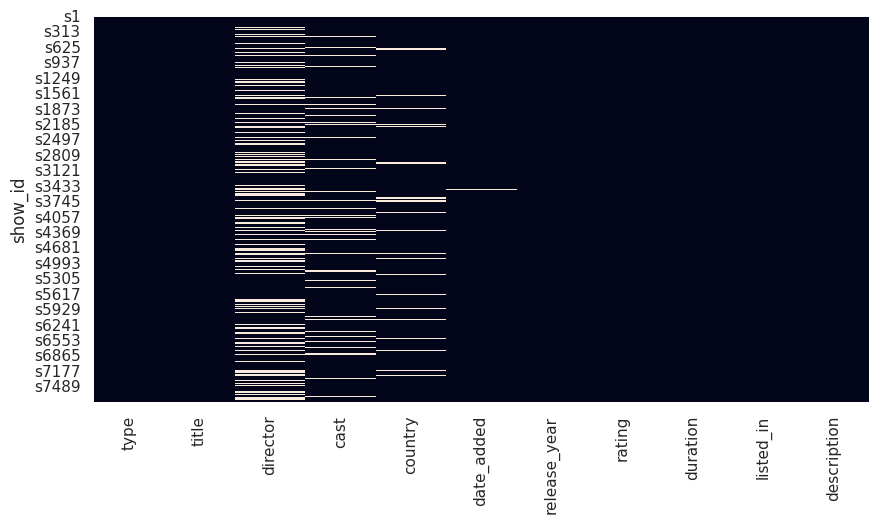

In [9]:
# Visualizing the missing values
# Checking Null Value by plotting Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)

In [10]:
# Missing values in the dataset
df.isna().sum()

,0
type,0
title,0
director,2389
cast,718
country,507
date_added,10
release_year,0
rating,7
duration,0
listed_in,0


**There are many missing values in director, cast, country, date_added, and rating columns.**

In [11]:
# Checking the unique values in each attribute of the dataset
df.nunique()

,0
type,2
title,7787
director,4049
cast,6831
country,681
date_added,1565
release_year,73
rating,14
duration,216
listed_in,492


* The missing values in the director, cast, and country attributes can be replaced with 'Unknown'
* 10 records with missing values in the date_added column can be dropped.
* The missing values in rating can be imputed with its mode, since this attribute is discrete.

**처음엔 이렇게 많은 결측치를 다 Unknown으로 채운 것에 의문을 가졌다. 이걸 다 unknown으로 하면 의미가 있나? 싶었다. 그래서 상황에 따른 결측치 처리법을 알아봤다.**

(1)**'알수없음'으로 채우는 경우**
: 단순 통계 분석이나 시각화가 목적일 때, 결측치가 분석 대상이 아닐 때
- 장점: 결측치 빠르게 처리
- 단점: 추천시스템이나 NLP모델에서 성능저하 가능

(2) **Imputation**
- 장점: 더 정교한 대체 가능
- 단점: 대체한 값이 오히려 노이즈가 될 수 있음.


(3) **결측치 행 제거**
: 결측치가 전체의 아주 일부일 때
- 장점: 노이즈 제거
- 단점: 데이터 손실 발생

In [12]:
# Handling the missing values
df[['director','cast','country']] = df[['director','cast','country']].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.dropna(axis=0, inplace = True)

In [13]:
df.shape

(7777, 11)

We have successfully handled all the missing values in the dataset.

## **4.3. Country, listed_in:**

In [14]:
# Top countries
df.country.value_counts()

,count
country,
United States,2549
India,923
Unknown,506
United Kingdom,396
Japan,225
...,...
"Peru, United States, United Kingdom",1
"Saudi Arabia, United Arab Emirates",1
"United Kingdom, France, United States, Belgium",1


In [15]:
# Genre of shows
df.listed_in.value_counts()

,count
listed_in,
Documentaries,334
Stand-Up Comedy,321
"Dramas, International Movies",320
"Comedies, Dramas, International Movies",243
"Dramas, Independent Movies, International Movies",215
...,...
Sports Movies,1
"Crime TV Shows, TV Horror, TV Mysteries",1
"Children & Family Movies, Classic Movies, Dramas",1


* There are some movies / TV shows that were filmed in multiple countries, have multiple genres associated with it.
* To simplify the analysis, let's consider only the primary country where that respective movie / TV show was filmed.
* Also, let's consider only the primary genre of the respective movie / TV show.

In [16]:
# Choosing the primary country and primary genre to simplify the analysis - 리스트의 첫번째값만 저장한다는 코드.
df['country'] = df['country'].apply(lambda x: x.split(',')[0])
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(',')[0])

**한 컬럼 내 여러 정보가 있는 경우 맨 앞에 요소만 남겨서 단순화하는 방법도 있군.<br>
데이터 손실이 우려되지만, 간단한 방법인듯**

In [17]:
# contry in which a movie was produced
df.country.value_counts()

,count
country,
United States,2877
India,956
United Kingdom,576
Unknown,506
Canada,259
...,...
Jamaica,1
Cyprus,1
Greece,1


In [18]:
# genre of shows
df.listed_in.value_counts()

,count
listed_in,
Dramas,1384
Comedies,1074
Documentaries,751
Action & Adventure,721
International TV Shows,689
Children & Family Movies,502
Crime TV Shows,369
Kids' TV,357
Stand-Up Comedy,321


## **4.4. Typecasting 'duration' from string to integer**

In [19]:
# Splitting the duration column, and changing the datatype to integer
df['duration'] = df['duration'].apply(lambda x: int(x.split()[0]))

In [20]:
# Number of seasons for tv shows
df[df['type']=='TV Show'].duration.value_counts()

,count
duration,
1,1608
2,378
3,183
4,86
5,57
6,30
7,19
8,18
9,8


In [21]:
# Movie length in minutes
df[df['type']=='Movie'].duration.unique()

array([ 93,  78,  80, 123,  95, 119, 118, 143, 103,  89,  91, 149, 144,
       124,  87, 110, 128, 117, 100,  84,  99,  90, 102, 104, 105,  56,
       125,  81,  97, 106, 107, 109,  44,  75, 101,  37, 113, 114, 130,
        94, 140, 135,  82,  70, 121,  92, 164,  53,  83, 116,  86, 120,
        96, 126, 129,  77, 137, 148,  28, 122, 176,  85,  22,  68, 111,
        29, 142, 168,  21,  59,  20,  98, 108,  76,  26, 156,  30,  57,
       150, 133, 115, 154, 127, 146, 136,  88, 131,  24, 112,  74,  63,
        38,  25, 174,  60, 153, 158, 151, 162,  54,  51,  69,  64, 147,
        42,  79,  40,  45, 172,  10, 163,  55,  72,  61,  71, 160, 171,
        48, 139, 157,  15,  65, 134, 161,  62, 186,  49,  73,  58, 165,
       166, 138, 159, 141, 132,  52,  67,  34,  66, 312, 180,  47, 155,
        14, 177,  11,   9,  46, 145,   8,  12,  43,  50,  23, 185, 200,
       169,  27, 170, 196,  33, 181, 204,  32,  35, 167, 179, 193,  13,
       214,  17, 173, 192, 209, 187,  41, 182, 224, 233, 189, 15

In [22]:
# datatype of duration
df.duration.dtype

dtype('int64')

We have successfully converted the datatype of duration column to int.

## **4.5. Typecasting 'date_added' from string to datetime:**

In [23]:
# Typecasting 'date_added' from string to datetime
df["date_added"] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')

In [24]:
# first and last date on which a show was added on Netflix
df.date_added.min(),df.date_added.max()

(Timestamp('2008-01-01 00:00:00'), Timestamp('2021-01-16 00:00:00'))

The shows were added on Netflix between 1st January 2008 and 16th January 2021.

In [25]:
# Adding new attributes month and year of date added

df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year
df.drop('date_added', axis=1, inplace=True)

## **4.6. Rating:**

The ratings can be changed to age restrictions that apply on certain movies and TV shows.

[Reference](https://www.primevideo.com/help/ref=atv_hp_nd_cnt?nodeId=GFGQU3WYEG6FSJFJ)

<Axes: xlabel='rating', ylabel='count'>

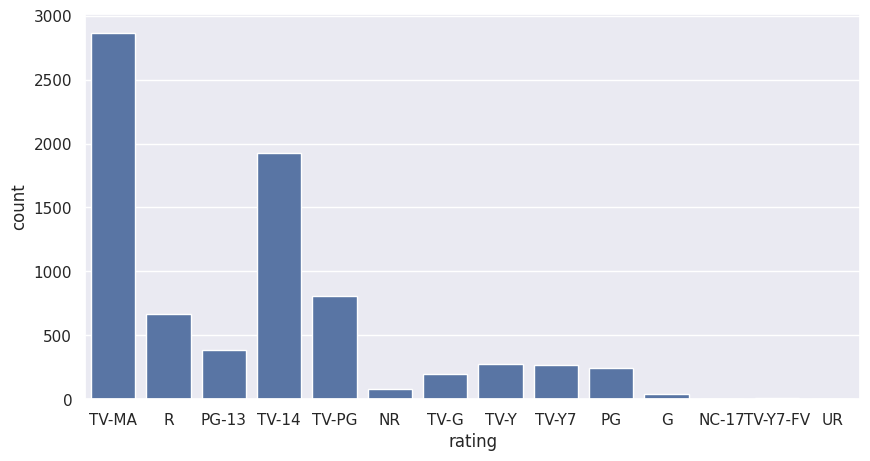

In [26]:
# Age ratings for shows in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)

**Highest number of shows on Netflix are rated by TV-MA, followed by TV-14 and TV-PG**

In [27]:
# Age ratings
df.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y',
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [28]:
# Changing the values in the rating column
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

df['rating'].replace(rating_map, inplace = True)
df['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

<Axes: xlabel='rating', ylabel='count'>

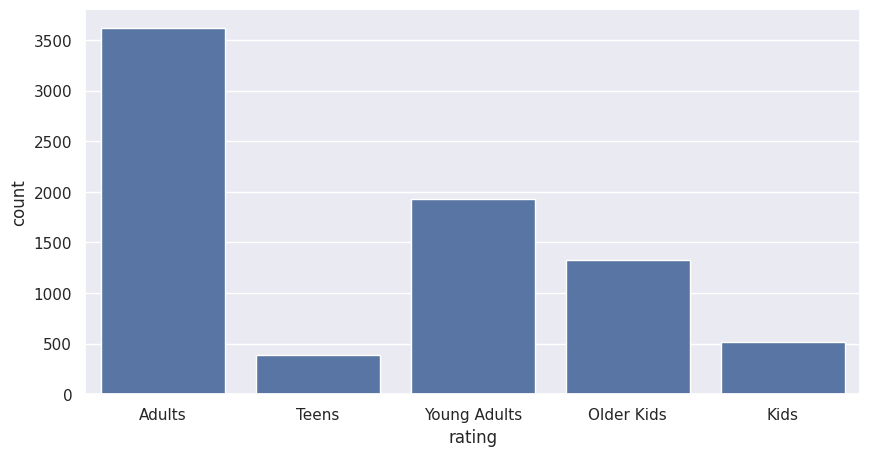

In [29]:
# Age ratings for shows in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)

**Around 50% of shows on Netflix are produced for adult audience. Followed by young adults, older kids and kids. Netflix has the least number of shows that are specifically produced for teenagers than other age groups.**

**rating이 콘텐츠 평점인 줄 알았는데 그게 아니었다..
권장 연령을 명시하는 콘텐츠 등급 체계였다. 그래서 나이랑 연관지었구나
타겟 나이층을 정리해서 넷플릭스가 어느 연령층에 콘텐츠 공급을 주력하는지 파악하는 흐름이 인상적이었.**

# **5. Exploratory Data Analysis:**

## **5.1. Univatiate Analysis:**

Text(0.5, 1.0, 'Movies and TV Shows in the dataset')

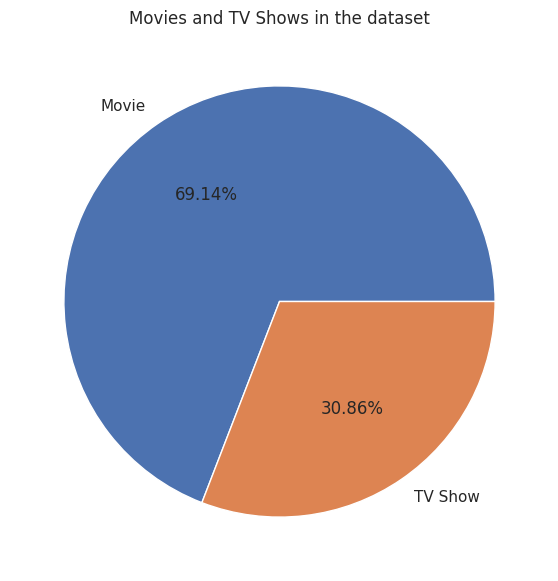

In [30]:
# Number of Movies and TV Shows in the dataset
plt.figure(figsize=(7,7))
df.type.value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.ylabel('')
plt.title('Movies and TV Shows in the dataset')

* **There are more movies (69.14%) than TV shows (30.86%)  in the dataset.**

Text(0.5, 1.0, 'Top 10 directors by number of shows directed')

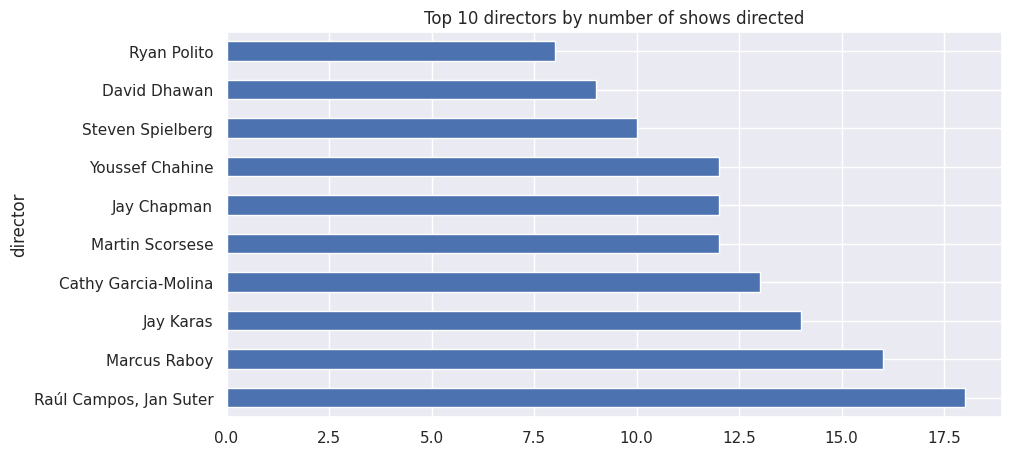

In [31]:
# Top 10 directors in the dataset
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 directors by number of shows directed')

* **Raul Campos and Jan Suter together have directed 18 movies / TV shows, higher than anyone in the dataset.**

Text(0.5, 1.0, ' Top 10 countries with the highest number of shows')

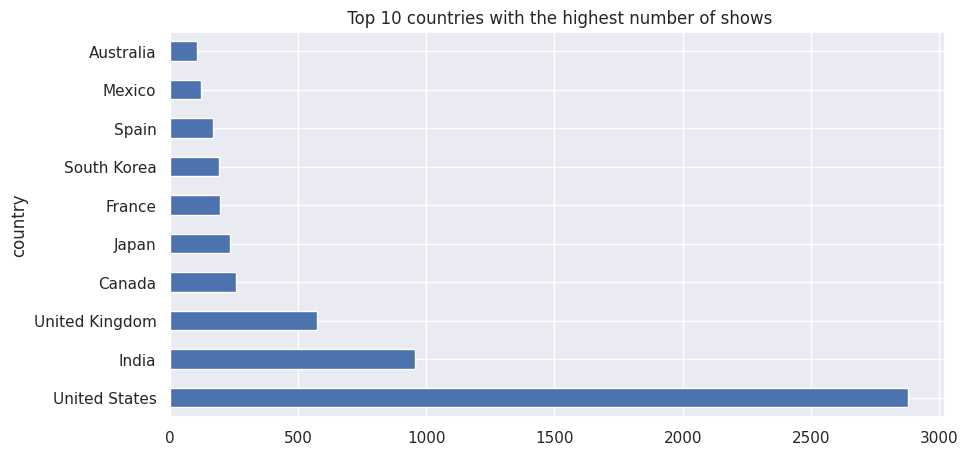

In [32]:
# Top 10 countries with the highest number movies / TV shows in the dataset
plt.figure(figsize=(10,5))
df[~(df['country']=='Unknown')].country.value_counts().nlargest(10).plot(kind='barh')
plt.title(' Top 10 countries with the highest number of shows')

* **The highest number of movies / TV shows were based out of the US, followed by India and UK.**

In [33]:
# % share of movies / tv shows by top 3 countries
df.country.value_counts().nlargest(3).sum()/len(df)*100

np.float64(56.69281213835669)

In [34]:
# % share of movies / tv shows by top 10 countries
df.country.value_counts().nlargest(10).sum()/len(df)*100

np.float64(78.32068921177832)

* **The top 3 countries together account for about 56% of all movies and TV shows in the dataset.**
* **This value increases to about 78% for top ten countries.**

Text(0.5, 1.0, 'distribution by released year')

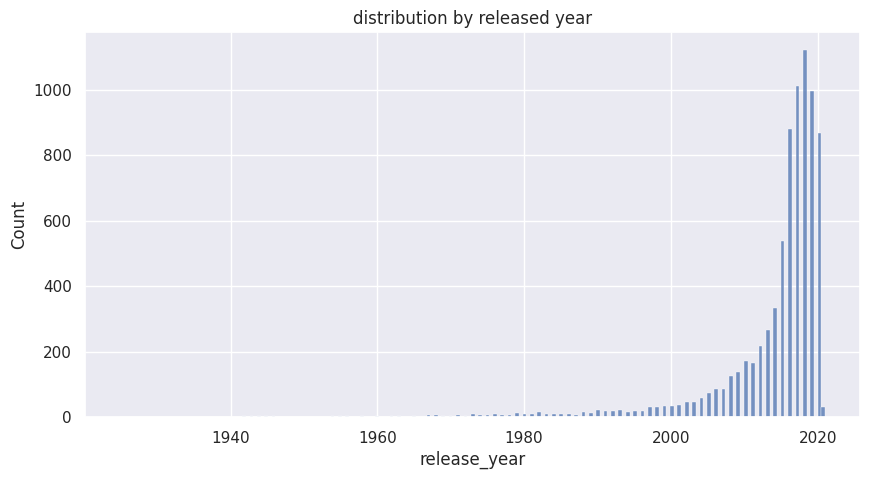

In [35]:
# Visualizing the year in which the movie / tv show was released
plt.figure(figsize=(10,5))
sns.histplot(df['release_year'])
plt.title('distribution by released year')

* **Netflix has greater number of new movies / TV shows than the old ones.**

Text(0.5, 1.0, 'Top 10 genres')

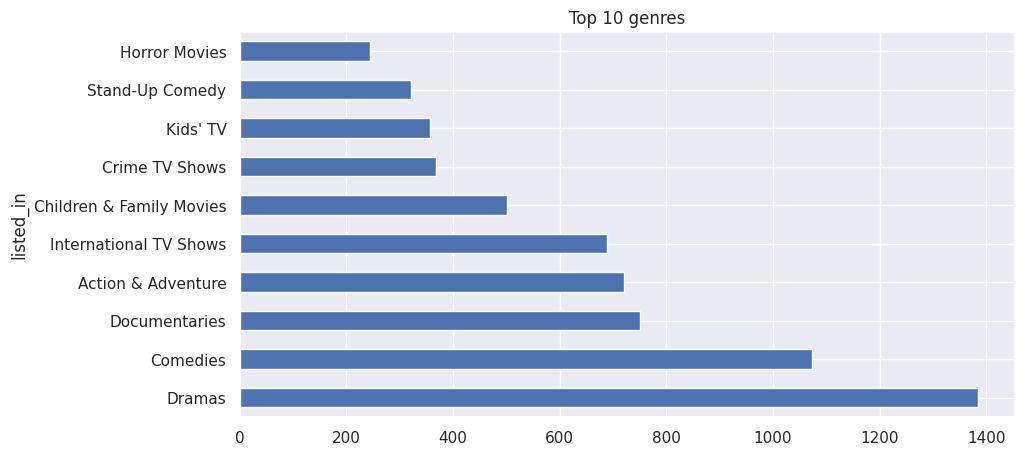

In [36]:
# Top 10 genres
plt.figure(figsize=(10,5))
df.listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres')

In [37]:
# Share of top 3 genres
df.listed_in.value_counts().nlargest(3).sum()/len(df)*100

np.float64(41.26269769834126)

In [38]:
# Share of top 10 genres
df.listed_in.value_counts().nlargest(10).sum()/len(df)*100

np.float64(82.44824482448246)

* **The dramas is the most popular genre followed by comedies and documentaries.**
* **These three genres account for about 41% of all movies and TV shows.**
* **This value increases to about 82% for top 10 genres.**

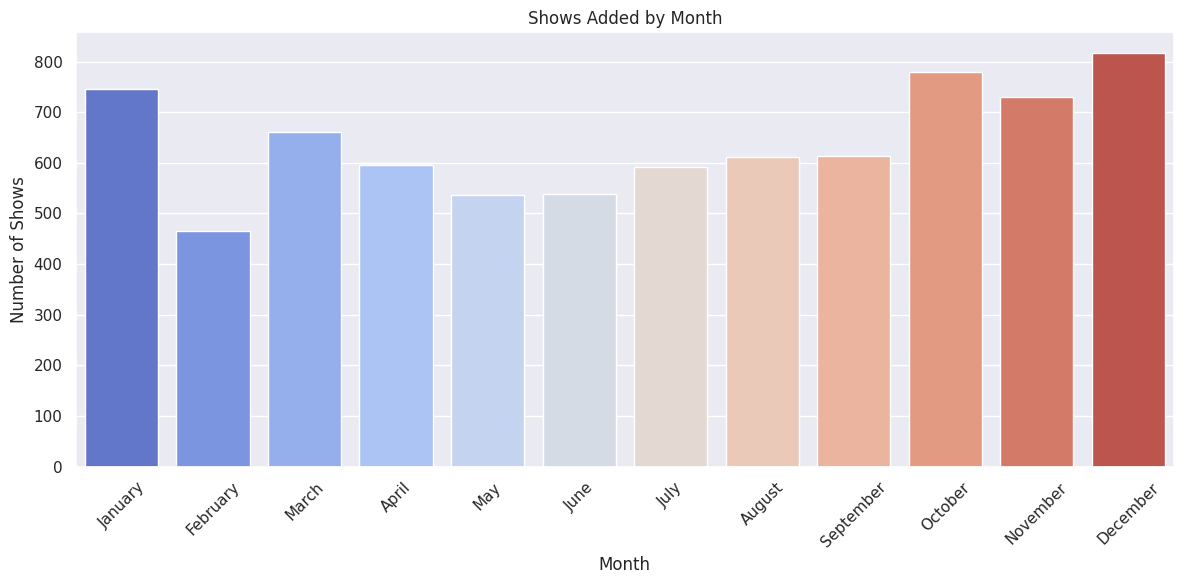

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# 월을 문자열로 바꾸고 순서 지정
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Drop rows where 'month_added' is NaN
df_cleaned = df.dropna(subset=['month_added']).copy()

# 숫자형 월을 문자열로 변환
df_cleaned['month_added'] = df_cleaned['month_added'].apply(lambda x: month_order[int(x)-1])

# 시각화
plt.figure(figsize=(12,6))
sns.countplot(x='month_added', data=df_cleaned, order=month_order, palette='coolwarm')
plt.title('Shows Added by Month')
plt.xlabel('Month')
plt.ylabel('Number of Shows')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

도저히 시각화 자료를 해석할 수 없겠어서 Gemini한테 코드 수정해달라했다.

* **Over the years a greater number of shows were added in the months of October, November, December, and January.**

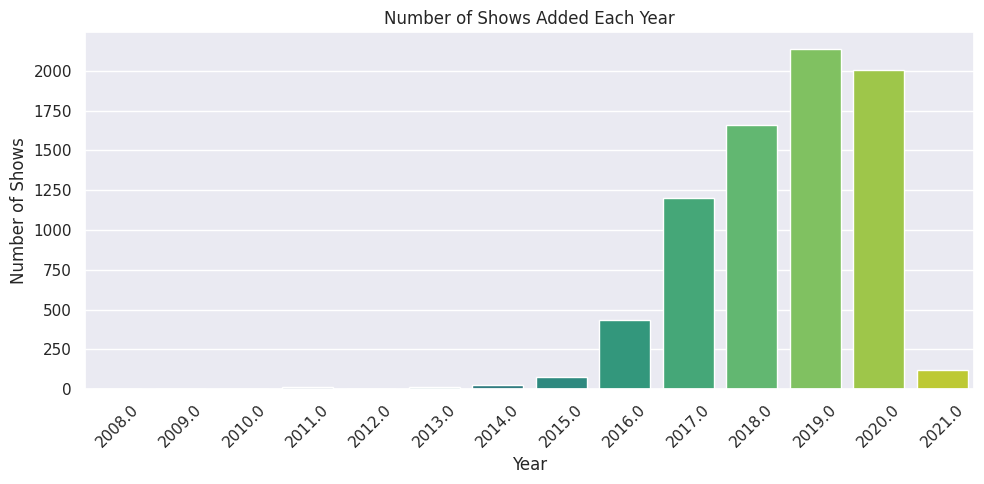

In [40]:
plt.figure(figsize = (10,5))
sns.countplot(x='year_added', data=df, palette='viridis')
plt.title('Number of Shows Added Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Shows')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* **Netflix continuous to add more shows on its platform over the years.**
* **There is a decrease in the number of shows added in the year 2020, which might be attributed to the covid-19-induced lockdowns, which halted the creation of shows.**
* **We have Netflix data only up to 16th January 2021, hence there are less movies added in this year.**

콘텐츠 공급 수가 상승하다가 2021년에 뚝 떨어졌다. 이런 데이터 양상을 보면 작성자처럼 왜 이런 현상이 나타났을지에 대해 고민해보자.

Text(0.5, 1.0, 'Number of shows on Netflix for different age groups')

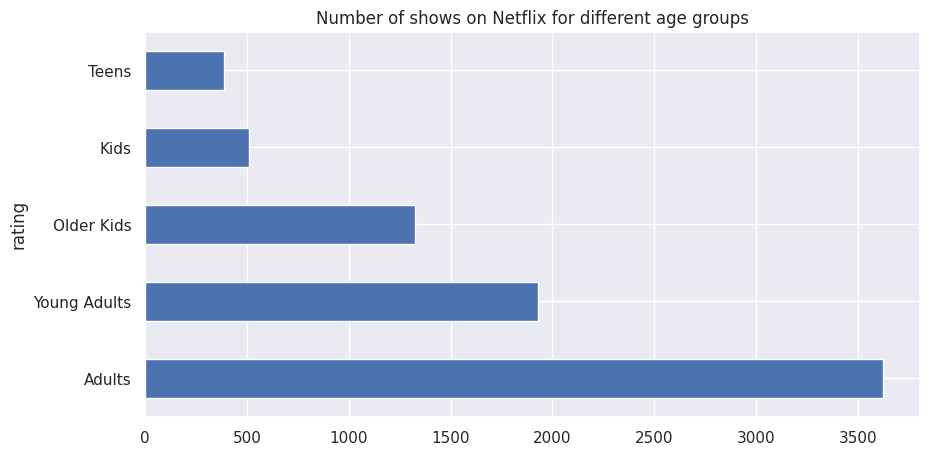

In [41]:
# Number of shows on Netflix for different age groups
plt.figure(figsize=(10,5))
df.rating.value_counts().plot(kind='barh')
plt.title('Number of shows on Netflix for different age groups')

* **The majority of the shows on Netflix are catered to the needs of adult and young adult population.**

## **5.2. Bivariate analysis:**

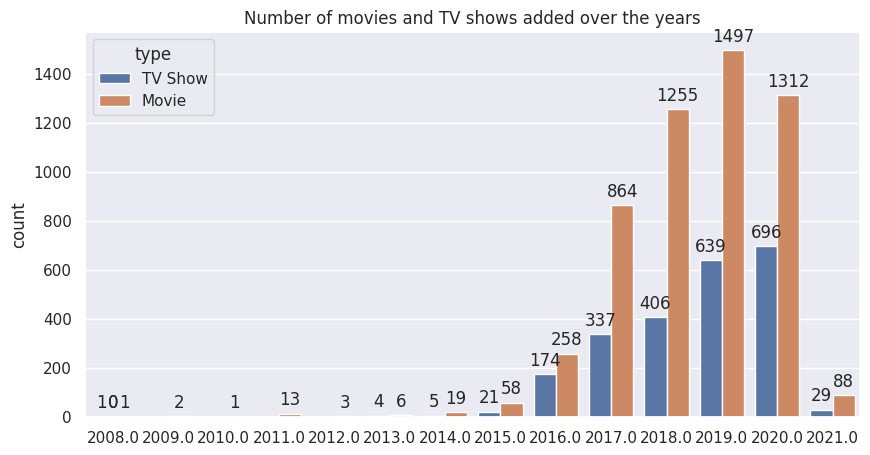

In [42]:
# Number of movies and TV shows added over the years
plt.figure(figsize=(10,5))
p = sns.countplot(x='year_added',data=df, hue='type')
plt.title('Number of movies and TV shows added over the years')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

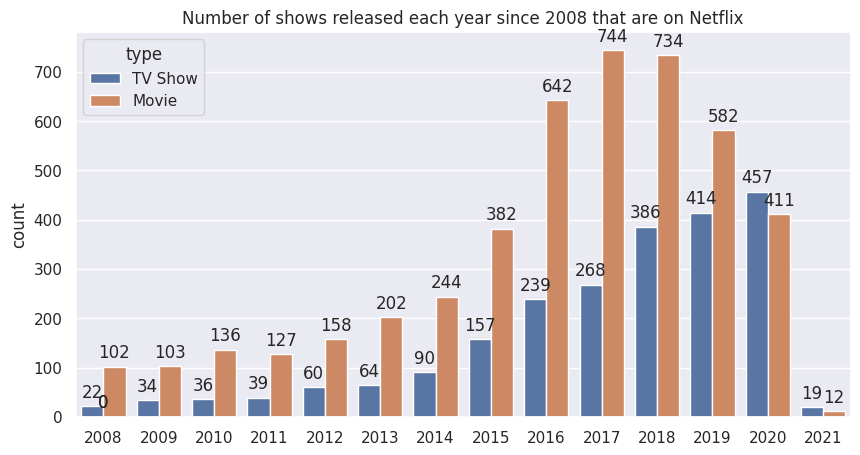

In [43]:
# Number of shows released each year since 2008
order = range(2008,2022)
plt.figure(figsize=(10,5))
p = sns.countplot(x='release_year',data=df, hue='type',
                  order = order)
plt.title('Number of shows released each year since 2008 that are on Netflix')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

* **Over the years, Netflix has consistently focused on adding more shows in its platform.**
* **Though there was a decrease in the number of movies added in 2020, this pattern did not exist in the number of TV shows added in the same year.**
* **This might signal that Netflix is increasingly concentrating on introducing more TV series to its platform rather than movies.**

**영화보다 티비 시리즈에 더 투자하는 이유는 시청자 유치 때문이 아닐까.<br>
티비 시리즈를 오래 방영해야 이용자수를 오랫동안 확보할 수 있기 때문.**

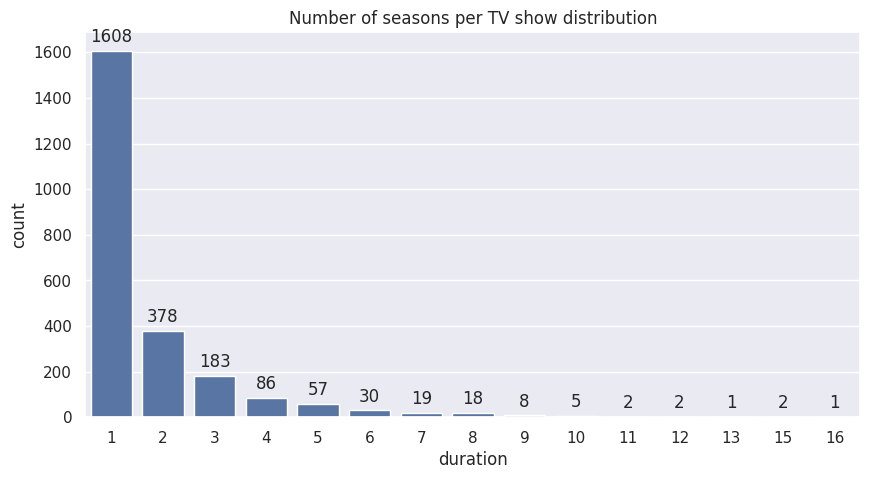

In [44]:
# Seasons in each TV show
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
p = sns.countplot(x='duration',data=df[df['type']=='TV Show'])
plt.title('Number of seasons per TV show distribution')

for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [45]:
# % of tv shows with just 1 season
len(df[(df['type']=='TV Show') & (df['duration']==1)]) / len(df[df['type']=='TV Show'])* 100

67.0

* **The TV series in the dataset have up to 16 seasons, however the bulk of them only have one. This might mean that the majority of TV shows has only recently begun, and that further seasons are on the way.**
* **There are very few TV shows that have more than 8 seasons.**

Text(0.5, 1.0, 'Movie duration distribution')

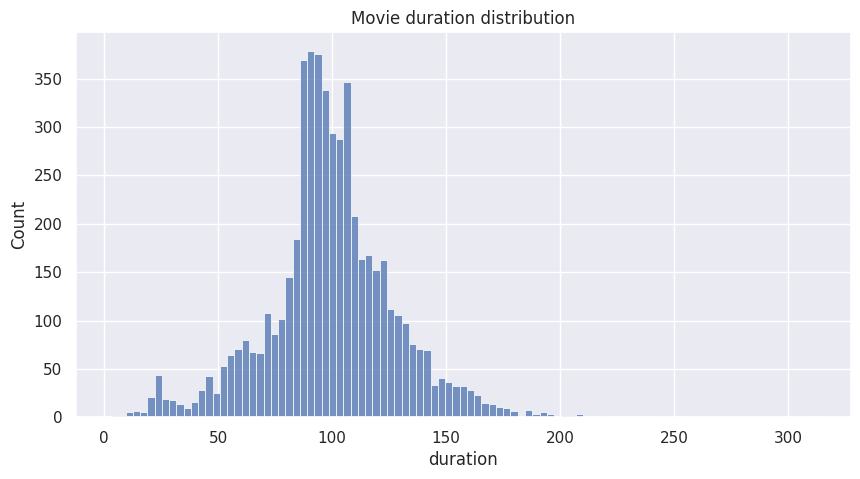

In [46]:
# length of movie analysis
plt.figure(figsize=(10,5))
sns.histplot(x='duration',data=df[df['type']=='Movie'])
plt.title('Movie duration distribution')

In [47]:
# Movie statistics
df[df['type']== 'Movie'].duration.describe()

,duration
count,5377.000000
mean,99.307978
std,28.530881
min,3.000000
25%,86.000000
50%,98.000000
75%,114.000000
max,312.000000


* **The length of a movie may range from 3 min to 312 minutes, and the distribution is almost normally distributed.**

Text(0.5, 0, 'Year')

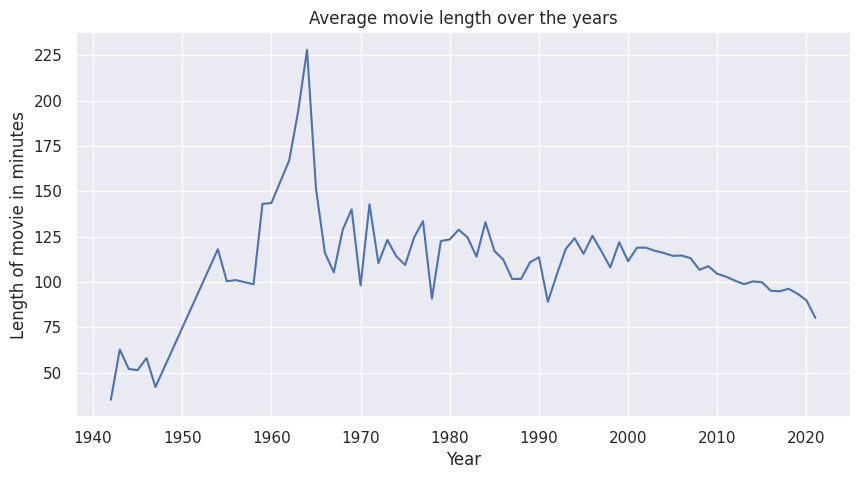

In [48]:
# Average movie length over the years
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].groupby('release_year')['duration'].mean().plot(kind='line')
plt.title('Average movie length over the years')
plt.ylabel('Length of movie in minutes')
plt.xlabel('Year')

In [49]:
# Movie release year statistics
df[df['type']== 'Movie'].release_year.describe()

,release_year
count,5377.000000
mean,2012.920030
std,9.663282
min,1942.000000
25%,2012.000000
50%,2016.000000
75%,2018.000000
max,2021.000000


* **Netflix has several movies on its site, including those that were released in way back 1942.**
* **As per the plot, movies made in the 1940s had a fairly short duration on average.**
* **On average, movies made in the 1960s have the longest movie length.**
* **The average length of a movie has been continuously decreasing since the 2000s.**

Text(0.5, 1.0, 'Top 10 genres for movies')

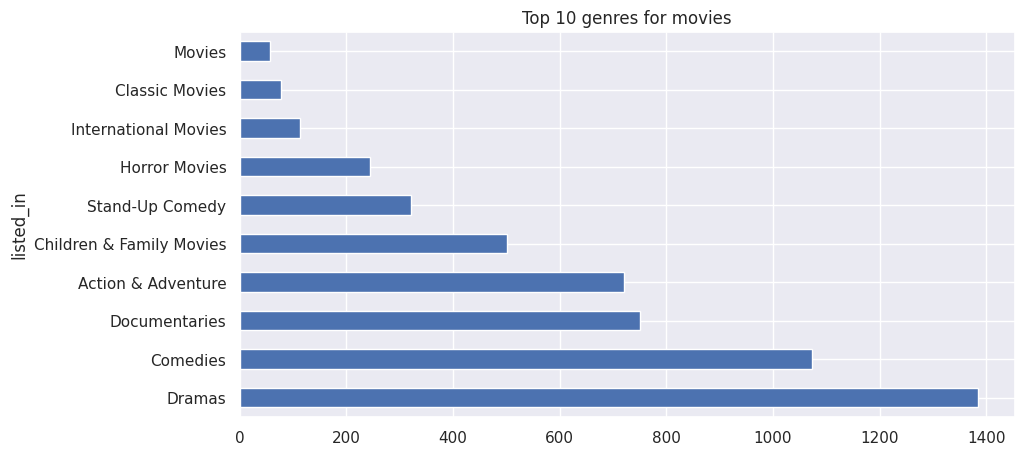

In [50]:
# Top 10 genre for movies
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for movies')

* **Dramas, comedies, and documentaries are the most popular genre for the movies on Netflix.**

Text(0.5, 1.0, 'Top 10 genres for TV Shows')

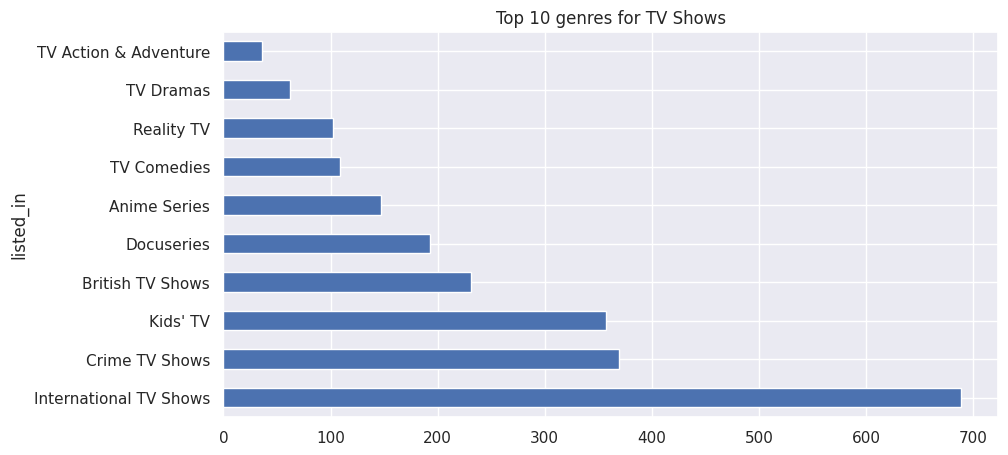

In [51]:
# Top 10 genre for tv shows
plt.figure(figsize=(10,5))
df[df['type']=='TV Show'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for TV Shows')

* **International, crime, and kids are the most popular genre for TV shows on Netflix.**

Text(0.5, 1.0, 'Top 10 movie directors')

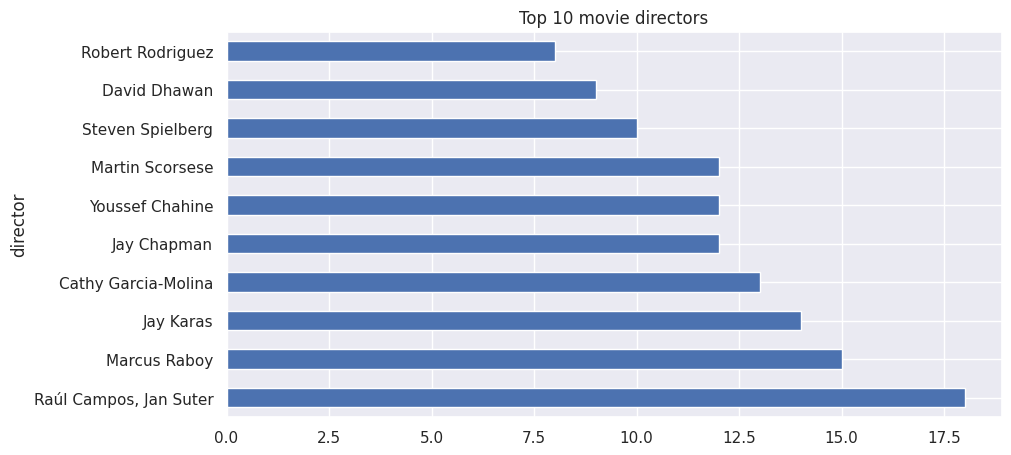

In [52]:
# Top 10 movie directors
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown') & (df['type']=='Movie')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 movie directors')

* **Raul Campos and Jan Suter have togather directed in 18 movies, higher than anyone yet.**
* **This is followed by Marcus Roboy, Jay Karas, and Cathy Gracia-Molina**

Text(0.5, 1.0, 'Top 10 TV show directors')

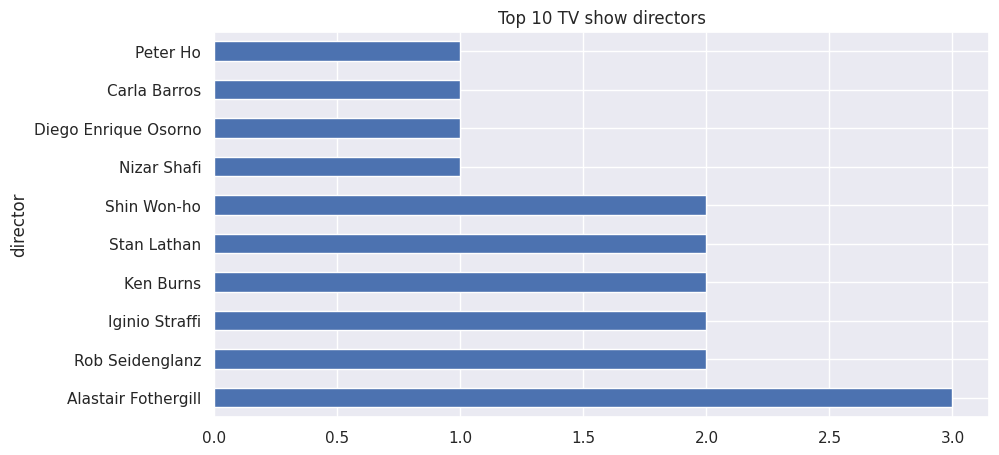

In [53]:
# Top 10 TV show directors
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown') & (df['type']=='TV Show')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 TV show directors')

* **Alastair Fothergill has directed three TV shows, the most of any director.**
* **Only six directors have directed more than one television show.**

Text(0.5, 1.0, 'Actors who have appeared in highest number of movies')

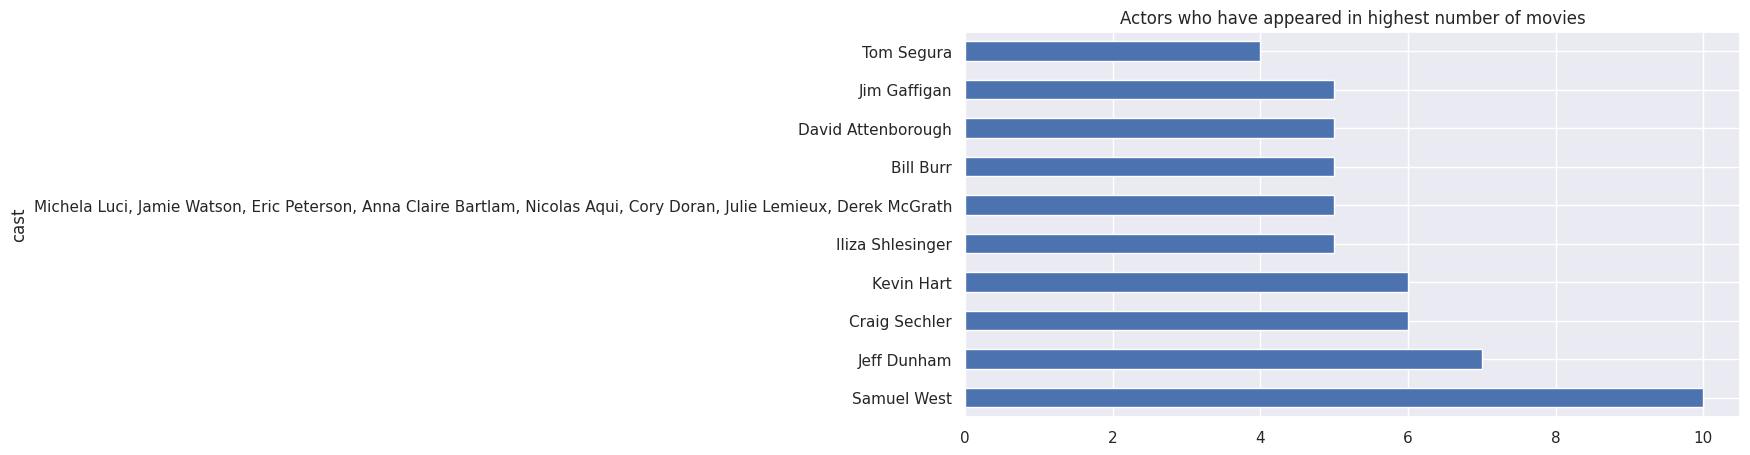

In [54]:
# Top actors for movies
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='Movie')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title('Actors who have appeared in highest number of movies')

* **Samuel West has appeared in 10 movies, followed by Jeff Dunham with 7 movies.**

Text(0.5, 1.0, 'Actors who have appeared in highest number of TV shows')

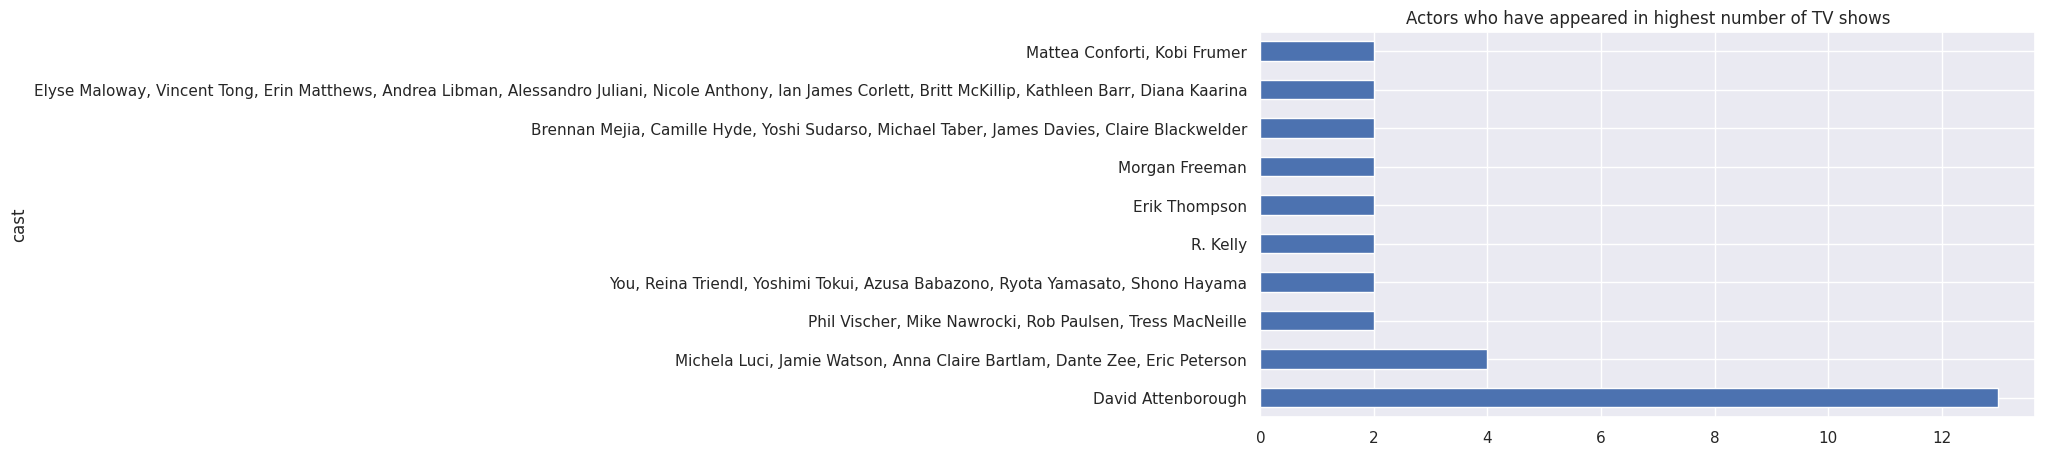

In [55]:
# Top actors for TV shows
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='TV Show')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title('Actors who have appeared in highest number of TV shows')

* **David Attenborough has appeared in 13 TV shows, followed by Michela Luci, Jamie Watson, Anna Claire Bartlam, Dante Zee, Eric Peterson with 4 TV shows.**

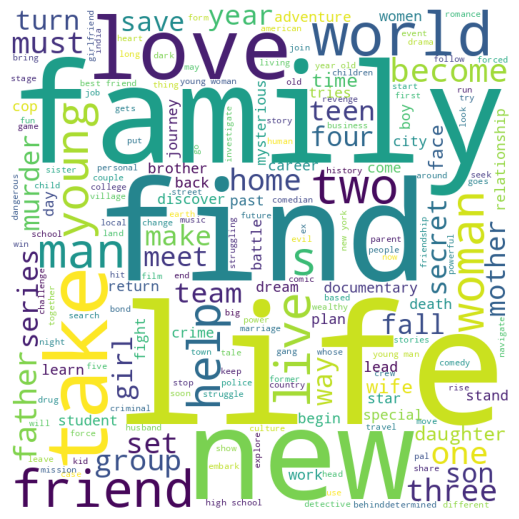

In [56]:
# Building a wordcloud for the movie descriptions
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.description.values:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image
plt.figure(figsize = (10,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

* **Some keywords in Netflix show descriptions: life, family, new, love, young, world, group, death, man, woman, murder, son, girl, documentary, secret.**

# **6. Data preprocessing:**

## **6.1. Modelling Approach:**
1. Select the attributes based on which you want to cluster the shows
2. Text preprocessing: Remove all non-ascii characters, stopwords and punctuation marks, convert all textual data to lowercase.
3. Lemmatization to generate a meaningful word out of corpus of words
4. Tokenization of corpus
5. Word vectorization
6. Dimensionality reduction
6. Use different algorithms to cluster the movies, obtain the optimal number of clusters using different techniques
7. Build optimal number of clusters and visualize the contents of each cluster using wordclouds.

We will cluster the shows on Netflix based on the following attributes:
* Director
* Cast
* Country
* Listed in (genres)
* Description

In [57]:
# Using the original dataset for clustering since
# it does not require handling missing values
df1 = original_df.copy()

In [58]:
df1.fillna('',inplace=True)

**해당 데이터에는 문자형 데이터가 많기 때문에 각각 따로 벡터화하면 차원이 많아지고 정보가 분산된다. 그래서 모든 칼럼을 하나로 합쳐서 요약 텍스트처럼 만들면 벡터화가 간단해지고 유사도 계산도 더 직관적으로 할 수 있다.**

**그래서 문자형 데이터가 많은 경우의 클러스터링은 텍스트 컬럼 합치기-> 벡터화-> 유사도 계산-> 클러스터링 순으로 진행된다.**


**수치형 컬럼이 있을 경우, 정규화를 통해 수치형 컬럼들의 스케일을 맞추고 텍스트 벡터와 수치 벡터를 수평결합한다.**

In [59]:
# Combining all the clustering attributes into a single column

df1['clustering_attributes'] = (df1['director'] + ' ' +
                                df1['cast'] +' ' +
                                df1['country'] +' ' +
                                df1['listed_in'] +' ' +
                                df1['description'])

In [60]:
df1['clustering_attributes'][40]

'Muharrem Gülmez Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem Gülmez, Elif Nur Kerkük, Tarık Papuççuoğlu, Suzan Aksoy, Doğa Konakoğlu, Esin Eden, Deniz Özerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

* **We have successfully added all the necessary data into a single column**

## **6.2. Removing non-ASCII characters:**

**영문자, 숫자, 기호 외의 문자들을 제거하는 함수 <br>  
-> 하는 이유: 텍스트 정제, 일관성 확보, 벡터화 오류 방지**

In [61]:
# function to remove non-ascii characters

def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [62]:
# remove non-ascii characters
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

In [63]:
df1['clustering_attributes'][40]

'Muharrem Gulmez Erdem Yener, Ayhan Tas, Emin Olcay, Muharrem Gulmez, Elif Nur Kerkuk, Tark Papuccuoglu, Suzan Aksoy, Doga Konakoglu, Esin Eden, Deniz Ozerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

* **We have successfully removed all non-ascii characters from the corpus.**

## **6.3. Remove stopwords and lower case:**

**stopwords는 불용어로, 텍스트 분석에서 의미없는 단어들을 말한다. <br>
이런 단어들은 빈도가 높지만 의미없어서 텍스트 벡터화 전에 제거해야한다.**

In [64]:
# extracting the stopwords from nltk library
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all',
       'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at',
       'be', 'because', 'been', 'before', 'being', 'below', 'between',
       'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did',
       'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don',
       "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further',
       'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
       "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers',
       'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd",
       'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it',
       "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll',
       'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn',
       "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not',
       'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'ot

In [65]:
# function to remove stop words
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [66]:
# Removing stop words
df1['clustering_attributes'] = df1['clustering_attributes'].apply(stopwords)

In [67]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener, ayhan tas, emin olcay, muharrem gulmez, elif nur kerkuk, tark papuccuoglu, suzan aksoy, doga konakoglu, esin eden, deniz ozerman turkey comedies, international movies slacker owner public bath house rallies community save big developer comes town close open new mall.'

* **We have successfully removed all the stopwords and converted the corpus to lowercase.**

## **6.4. Remove punctuations**

In [68]:
# function to remove punctuations
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [69]:
# Removing punctuation marks
df1['clustering_attributes'] = df1['clustering_attributes'].apply(remove_punctuation)

In [70]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener ayhan tas emin olcay muharrem gulmez elif nur kerkuk tark papuccuoglu suzan aksoy doga konakoglu esin eden deniz ozerman turkey comedies international movies slacker owner public bath house rallies community save big developer comes town close open new mall'

* **We have successfully dropped all the punctuation marks from the corpus.**

## **6.5. Lemmatization:**

**단어 리스트에서 동사 형태를 원형으로 바꾸는 작업<br>
이 작업을 통해 다른 형태의 동일한 의미인 단어들을 통일시키기 때문에 정확한 비교분석을 할 수 있음.**

In [71]:
# function to lemmatize the corpus
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [72]:
# Lemmatization
df1['clustering_attributes'] = lemmatize_verbs(df1['clustering_attributes'])

In [73]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener ayhan tas emin olcay muharrem gulmez elif nur kerkuk tark papuccuoglu suzan aksoy doga konakoglu esin eden deniz ozerman turkey comedies international movies slacker owner public bath house rallies community save big developer comes town close open new mall'

* **We have lemmatized the corpus.**
-> corpus: (몸체, 집합) 문장, 문서, 단어 등 텍스트로 구성된 데이터셋 전체를 가리킴.

## **6.6. Tokenization:**

**문장이나 문서처럼 긴 텍스트를 작은 단위로(=토큰으로) 쪼개는 작업.
즉 텍스트를 분석 가능한 형태로 바꾸는 것.**

In [74]:
tokenizer = TweetTokenizer()

In [75]:
df1['clustering_attributes'] = df1['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

* **The corpus is converted to tokens.**

## **6.7. Vectorization:**

* We can vectorize the corpus using TFIDF vectorizer, where TFIDF stands for - Term Frequency Inverse Document Frequency.

\begin{align}
        TF = \frac{Number\ of\ times\ term\ t\ appears\ in\ a\ document}{Total\ number\ of\ terms\ in\ the\ document}
    \end{align}

\begin{align}
        IDF(t) = log_e(\frac{Total\  number \ of \ documents}{ Number\ of\ documents\ with\ term\ t\ in\ it })
    \end{align}

\begin{align}
TFIDF = {TF\ *\ IDF}
    \end{align}

**단어의 중요도를 계산해서 텍스트를 숫자 벡터로 바꾸는 방법.**<br>
**즉, 단어의 정보량을 기반으로 텍스트를 수치화하는 방식.**<br>
**TF=단어의 빈도수**<br>
**IDF=전체 문서 중에서 얼마나 희귀한 단어인지**

**사용하는 이유**<br>
**1. 중요한 단어에 더 높은 점수 부여**<br>
**2. 불용어 자동으로 무시**<br>
**3. 텍스트 간 유사도 계산에 유리:<br> TF-IDF 벡터끼리 코사인 유사도를 계산하면 의미 기반 유사도를 비교할 수 있음.**

In [76]:
# clustering tokens saved in a variable
clustering_data = df1['clustering_attributes']

In [77]:
# Tokenization
def identity_tokenizer(text):
    return text

# Using TFIDF vectorizer to vectorize the corpus
# max features = 20000 to prevent system from crashing
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 20000)
X = tfidf.fit_transform(clustering_data)

In [78]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 235079 stored elements and shape (7787, 20000)>

In [79]:
# Shape of X
X.shape

(7787, 20000)

In [80]:
# data type of vector
type(X)

scipy.sparse._csr.csr_matrix

In [81]:
# convert X into array form for clustering
X = X.toarray()

## **6.8. Dimensionality reduction using PCA:**

**TF-IDF벡터가 수천, 수만개이면 고차원이어서 거리계산이 클러스터링이 잘 안된다.(퍼진 모양) 그래서 핵심정보만 남기기 위해 PCA를 통해 고차원 데이터를 압축하는 것.**

* We can use PCA (Principal component Analysis) to reduce the dimensionality of data.

In [82]:
# using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Text(0, 0.5, 'cumulative explained variance')

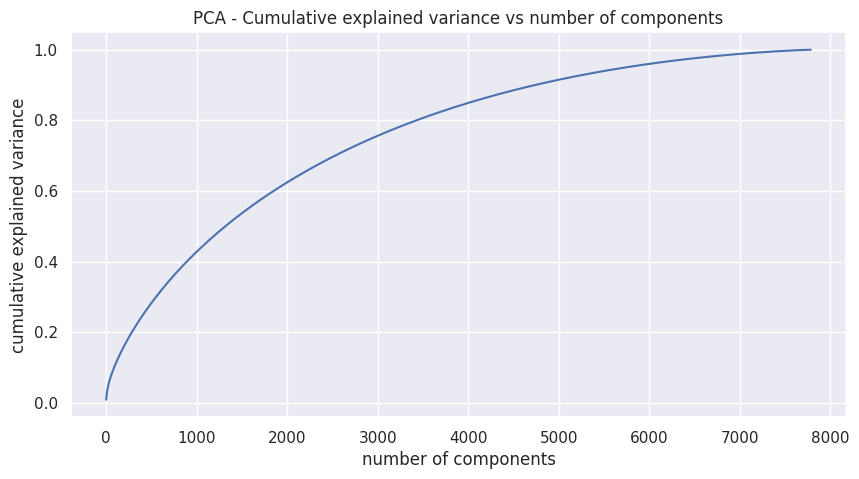

In [83]:
# Explained variance for different number of components
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

* We find that **100%** of the variance is explained by about **~7500 components**.
* Also, more than **80%** of the variance is explained just by **4000 components**.
* Hence to simplify the model, and reduce dimensionality, we can take the top 4000 components, which will still be able to capture more than 80% of variance.

In [84]:
# reducing the dimensions to 4000 using pca
pca = PCA(n_components=4000,random_state=42)
pca.fit(X)

PCA(n_components=4000, random_state=42)

In [85]:
# transformed features
x_pca = pca.transform(X)

In [86]:
# shape of transformed vectors
x_pca.shape

(7787, 4000)

We have successfully reduced the dimensionality of data using PCA.

# **7. Clusters implementation:**

## **7.1. K-Means Clustering:**

**데이터 포인트들 사이의 거리(유사도)를 계산해서 가까운 것끼리 묶고, 멀리 떨어진 것들은 다른 그룹으로 분리하는 방식.**

Building clusters using the K-means clustering algorithm.

Visualizing the elbow curve and Silhouette score to decide on the optimal number of clusters for K-means clustering algorithm.

Text(0, 0.5, 'WCSS')

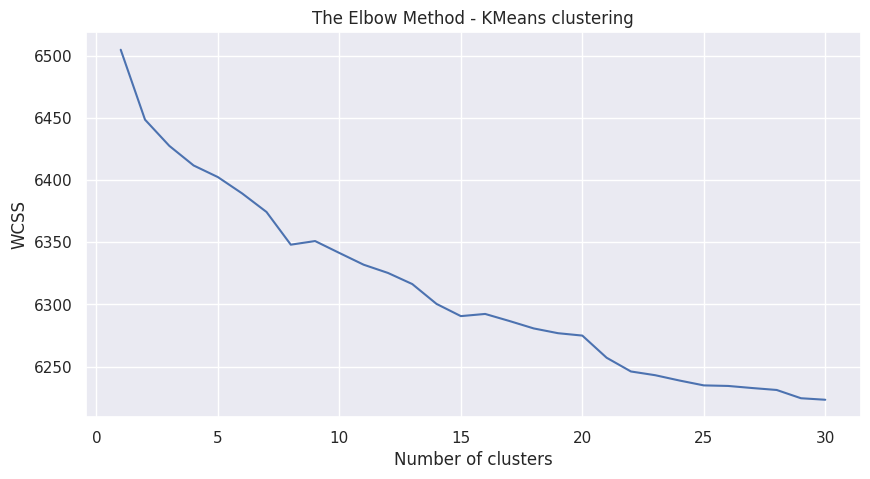

In [87]:
# Elbow method to find the optimal value of k
wcss=[]
for i in range(1,31):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

**The sum of squared distance between each point and the centroid in a cluster (WCSS) decreases with the increase in the number of clusters.**

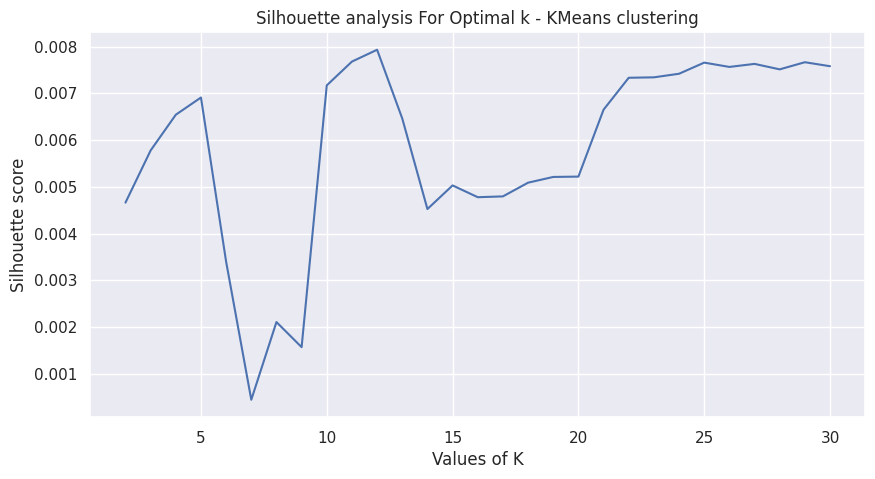

In [88]:
# Plotting Silhouette score for different umber of clusters
range_n_clusters = range(2,31)
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialize kmeans
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  cluster_labels = kmeans.labels_

  # silhouette score
  silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - KMeans clustering')
plt.show()

**실루엣 스코어는 클러스터링의 품질을 평가하는 지표고 1에 가까울수록 데이터가 자기 데이터에 속해있는 동시에 다른 클러스터와는 잘 분리되어있음을 뜻함. (0은 경계에 있다는 뜻) 그래서 1에 가까운, 가장 높은 실루엣 스코어를 가진 k값(k=클러스터 개수)을 찾아 최적의 클러스터 개수를 찾아야 함.**

* **The highest Silhouette score is obtained for 6 clusters.**

Building 6 clusters using the k-means clustering algorithm:

In [89]:
# Clustering the data into 19 clusters
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=33)
kmeans.fit(x_pca)

KMeans(n_clusters=6, random_state=33)

In [90]:
# Evaluation metrics - distortion, Silhouette score
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)

print((kmeans_distortion,kmeans_silhouette_score))

(6389.25571013337, np.float64(0.003399244187336403))


In [91]:
# Adding a kmeans cluster number attribute
df1['kmeans_cluster'] = kmeans.labels_

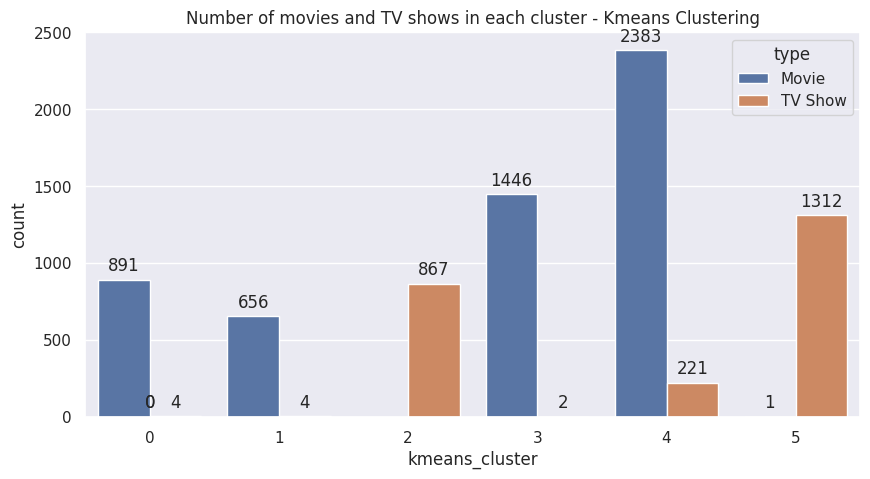

In [92]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='kmeans_cluster',data=df1, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

**Successfully built 6 clusters using the k-means clustering algorithm.**

### **7.1.1. Building wordclouds for different clusters built:**

In [93]:
# Building a wordcloud for the movie descriptions
def kmeans_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['kmeans_cluster']==cluster_num].description.values:

      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()

      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

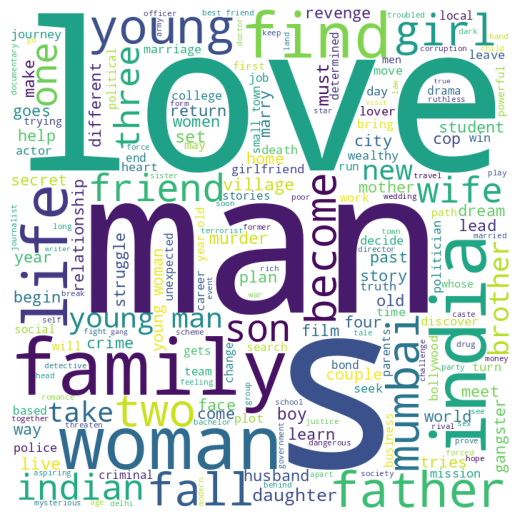

In [94]:
# Wordcloud for cluster 0
kmeans_worldcloud(0)

**Keywords observed in cluster 0: life, new, family, friend, save, help, discover, home, teen**

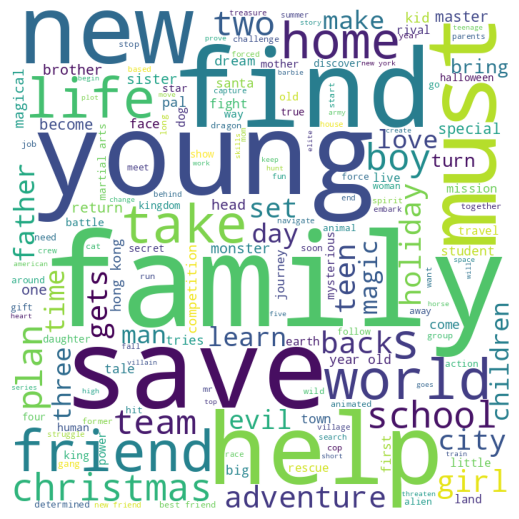

In [95]:
# Wordcloud for cluster 1
kmeans_worldcloud(1)

**Keywords observed in cluster 1: life, love, family, father, young, girl, man, woman, friend, daughter**

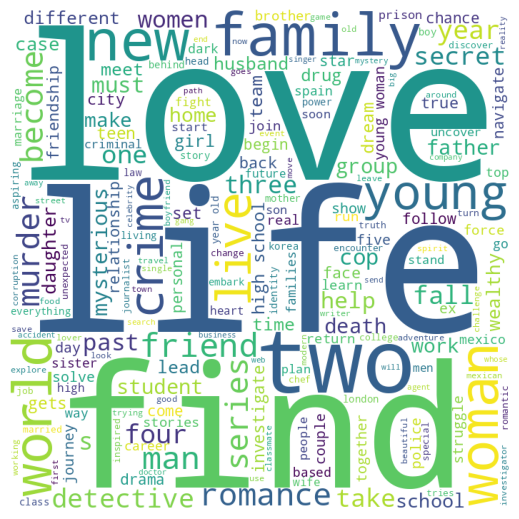

In [96]:
# Wordcloud for cluster 2
kmeans_worldcloud(2)

**Keywords observed in cluster 2: young, world, girl, mysterious, humanity, life, student, school, battle, demon, force**

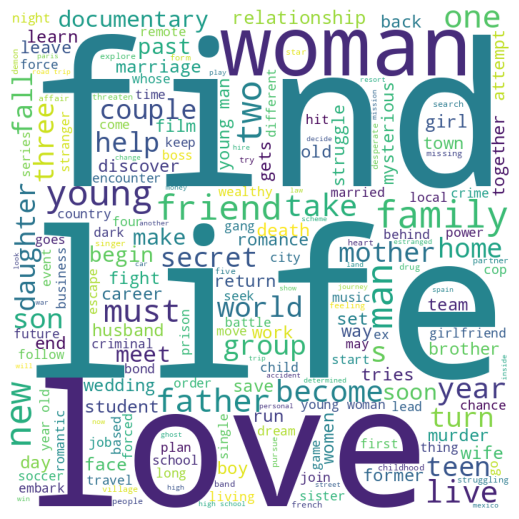

In [97]:
# Wordcloud for cluster 3
kmeans_worldcloud(3)

**Keywords observed in cluster 3: love, life, family, romance, crime, murder, world, adventure**

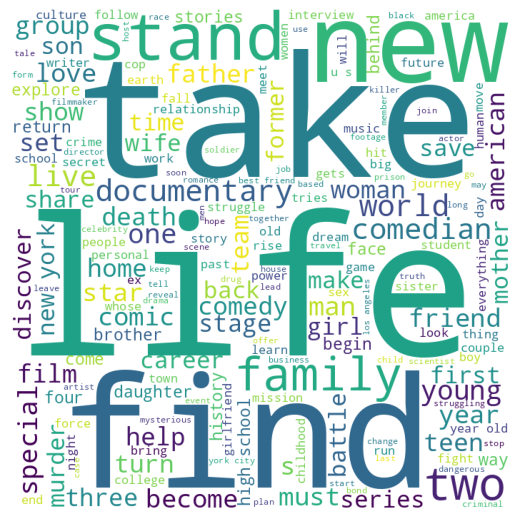

In [98]:
# Wordcloud for cluster 4
kmeans_worldcloud(4)

**Keywords observed in cluster 4: comedian, special, stand, comic, stage, sex, joke**

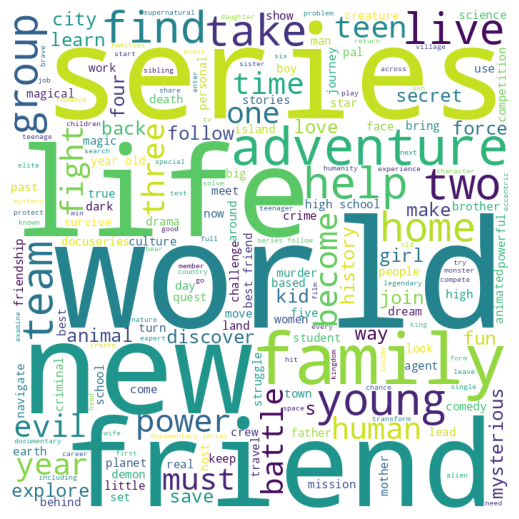

In [99]:
# Wordcloud for cluster 5
kmeans_worldcloud(5)

**Keywords observed in cluster 5: documentary, world, life, filmmaker, american, life**

## **7.2. Hierarchical clustering:**

**원리 비유 <br>
: 처음엔 풍선 하나하나가 독립적 그룹으로 존재, 이후 비슷한 풍선끼리 묶음. (예-빨간 풍선 2개 하나의 그룹으로) 그 다음에 비슷한 그룹끼리 또 묶음.(예-빨강 풍선 그룹+주황 풍선 그룹) 이런식으로 점점 큰 그룹을 만들어가면서 트리구조를 형성하는 알고리즘.**

Building clusters using the agglomerative (hierarchical) clustering algorithm.

Visualizing the dendrogram to decide on the optimal number of clusters for the agglomerative (hierarchical) clustering algorithm:

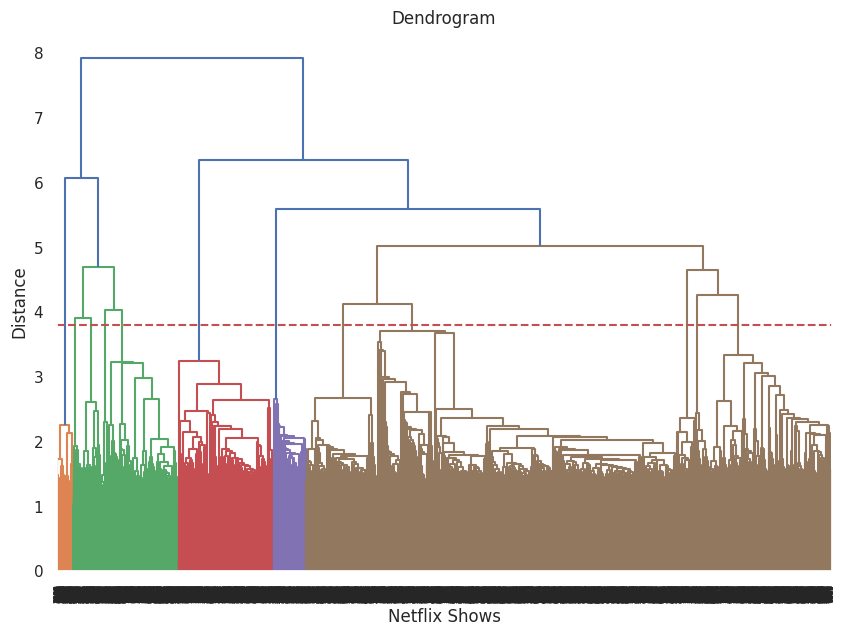

In [100]:
# Building a dendogram to decide on the number of clusters
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(x_pca, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Netflix Shows')
plt.ylabel('Distance')
plt.axhline(y= 3.8, color='r', linestyle='--')

**At a distance of 3.8 units, 12 clusters can be built using the agglomerative clustering algorithm.**

Building 12 clusters using the Agglomerative clustering algorithm:

In [101]:
# Fitting hierarchical clustering model
hierarchical = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')
hierarchical.fit_predict(x_pca)

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [ ]:
# Adding a kmeans cluster number attribute
df1['hierarchical_cluster'] = hierarchical.labels_

In [ ]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='hierarchical_cluster',data=df1, hue='type')
plt.title('Number of movies and tv shows in each cluster - Hierarchical Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Successfully built 12 clusters using the Agglomerative (hierarchical) clustering algorithm.

### **7.2.1. Building wordclouds for different clusters built:**

In [ ]:
# Building a wordcloud for the movie descriptions
def hierarchical_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['hierarchical_cluster']==cluster_num].description.values:

      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()

      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

In [ ]:
# Wordcloud for cluster 0
hierarchical_worldcloud(0)

**Keywords observed in cluster 0: life, new, find, family, save, friend, young, teen, adventure**

In [ ]:
# Wordcloud for cluster 1
hierarchical_worldcloud(1)

**Keywords observed in cluster 1: love, family, life, student, romance, school, woman, master, father**

In [ ]:
# Wordcloud for cluster 2
hierarchical_worldcloud(2)

**Keywords observed in cluster 2: life, new, series, crime, world, murder, history, detective**

In [ ]:
# Wordcloud for cluster 3
hierarchical_worldcloud(3)

**Keywords observed in cluster 3: family, life, love, friend, teen, woman, man, young, world, wedding, secret**

In [ ]:
# Wordcloud for cluster 4
hierarchical_worldcloud(4)

**Keywords observed in cluster 4: documentary, music, world, team, interview,history, family, career, battle, death**

In [ ]:
# Wordcloud for cluster 5
hierarchical_worldcloud(5)

**Keywords observed in cluster 5: family, life, mexico, young, new, woman, man, secret, spain, death, singer**

In [ ]:
# Wordcloud for cluster 6
hierarchical_worldcloud(6)

**Keywords observed in cluster 6: young, life, girl, world, friend, mysterious, demon, student, school, father**

In [ ]:
# Wordcloud for cluster 7
hierarchical_worldcloud(7)

**Keywords observed in cluster 7: love, life, woman, new, student, family, korea, secret, detective, young**

In [ ]:
# Wordcloud for cluster 8
hierarchical_worldcloud(8)

**Keywords observed in cluster 8: woman, man life, egypt, wealthy, money, young, love, revolution, struggling**

In [ ]:
# Wordcloud for cluster 9
hierarchical_worldcloud(9)

**Keywords observed in cluster 9: comedian, stand, life, comic, special, show, live, star, stage, hilarious, stories**

In [ ]:
# Wordcloud for cluster 10
hierarchical_worldcloud(10)

**Keywords observed in cluster 10: animal, nature, explore, planet, species, survive, natural, life, examine, earth**

In [ ]:
# Wordcloud for cluster 11
hierarchical_worldcloud(11)

**Keywords observed in cluster 11: love, man, woman, india, father, friend, girl, mumbai, city, learn, young**

# **8. Content based recommender system:**

* We can build a simple content based recommender system based on the similarity of the shows.
* If a person has watched a show on Netflix, the recommender system must be able to recommend a list of similar shows that s/he likes.
* To get the similarity score of the shows, we can use cosine similarity
* The similarity between two vectors (A and B) is calculated by taking the dot product of the two vectors and dividing it by the magnitude value as shown in the equation below. We can simply say that the CS score of two vectors increases as the angle between them decreases.

\begin{align}
        Cos(\theta) = \frac{A\ .\ B}{|A|\ .\ |B|}
    \end{align}

In [ ]:
# defining a new df for building a recommender system
recommender_df = df1.copy()

In [ ]:
# Changing the index of the df from show id to show title
recommender_df['show_id'] = recommender_df.index

**코사인 유사도는 벡터 간 유사도를 계산하기 때문에 토큰을 다시 벡터로 변환해야함**

In [ ]:
# converting tokens to string
def convert(lst):
  return ' '.join(lst)

recommender_df['clustering_attributes'] = recommender_df['clustering_attributes'].apply(lambda x: convert(x))

In [ ]:
# setting title of movies/Tv shows as index
recommender_df.set_index('title',inplace=True)

In [ ]:
# Count vectorizer
CV = CountVectorizer()
converted_matrix = CV.fit_transform(recommender_df['clustering_attributes'])

In [ ]:
# Cosine similarity
cosine_similarity = cosine_similarity(converted_matrix)

In [ ]:
cosine_similarity.shape

In [ ]:
# Developing a function to get 10 recommendations for a show
indices = pd.Series(recommender_df.index)

def recommend_10(title, cosine_sim = cosine_similarity):
  try:
    recommend_content = []
    idx = indices[indices == title].index[0]
    series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top10 = list(series.iloc[1:11].index)
    # list with the titles of the best 10 matching movies
    for i in top10:
      recommend_content.append(list(recommender_df.index)[i])
    print("If you liked '"+title+"', you may also enjoy:\n")
    return recommend_content

  except:
    return 'Invalid Entry'

In [ ]:
# Recommendations for 'A Man Called God'
recommend_10('A Man Called God')

In [ ]:
# Recommendations for 'Stranger Things'
recommend_10('Stranger Things')

In [ ]:
# Recommendations for 'Peaky Blinders'
recommend_10('Peaky Blinders')

In [ ]:
# Recommendations for 'Lucifer'
recommend_10('Lucifer')

In [ ]:
# Recommendations for 'XXX'
recommend_10('XXX')

Invalid because the show 'XXX' is not available on Netflix.

# **9. Conclusions:**

* In this project, we worked on a text clustering problem wherein we had to classify/group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.
* The dataset contained about 7787 records, and 11 attributes.
* We began by dealing with the dataset's missing values and doing exploratory data analysis (EDA).
* It was found that Netflix hosts more movies than TV shows on its platform, and the total number of shows added on Netflix is growing exponentially. Also, majority of the shows were produced in the United States, and the majority of the shows on Netflix were created for adults and young adults age group.
* It was decided to cluster the data based on the attributes: director, cast, country, genre, and description. The values in these attributes were tokenized, preprocessed, and then vectorized using TFIDF vectorizer.
* Through TFIDF Vectorization, we created a total of 20000 attributes.
* We used Principal Component Analysis (PCA) to handle the curse of dimensionality. 4000 components were able to capture more than 80% of variance, and hence, the number of components were restricted to 4000.
* We first built clusters using the k-means clustering algorithm, and the optimal number of clusters came out to be 6. This was obtained through the elbow method and Silhouette score analysis.
* Then clusters were built using the Agglomerative clustering algorithm, and the optimal number of clusters came out to be 12. This was obtained after visualizing the dendrogram.
* A content based recommender system was built using the similarity matrix obtained after using cosine similarity. This recommender system will make 10 recommendations to the user based on the type of show they watched.